# Visualize Real and Synthetic Data

In [1]:
# Expand views
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

2022-04-29 13:22:11.761323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 13:22:11.761339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


2022-04-29 13:22:13.411946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-29 13:22:13.411966: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-29 13:22:13.411981: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [4]:
sns.set_style('white')

In [5]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

In [6]:
seq_len = 24
n_seq = 18

## 1. Load Data

In [7]:
experiment = 0

In [8]:
df = pd.read_csv("data/swat_dataset_normal_v1.csv")

# We just use subsection of the dataset
df = df[:9000]
df.shape

(9000, 53)

In [9]:
# Get only float values
df = df[['LIT101',
         'AIT201', 'AIT202', 'AIT203',
         'DPIT301', 'FIT301', 'LIT301',
         'AIT402', 'LIT401',
         'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT503',
         'PIT501', 'PIT503', 'FIT601']]

In [10]:
tickers = list(df.columns)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)
real_data = []
for i in range(len(df) - seq_len):
    real_data.append(scaled_data[i:i + seq_len])

In [11]:
np.asarray(real_data).shape

(8976, 24, 18)

In [12]:
# Import synthetic data
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data_swat.npy')
synthetic_data.shape

(8960, 24, 18)

In [13]:
# Reshape the real data to have the same shape as the synthetic data
real_data = real_data[:synthetic_data.shape[0]]
np.asarray(real_data).shape

(8960, 24, 18)

## 2. Prepare Sample

In [14]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [15]:
# Get 250 data points of each attributes each with the batch size of 24
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [16]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [17]:
real_sample_2d.shape, synthetic_sample_2d.shape

((4500, 24), (4500, 24))

## 3. Visualize Data in 2D: Qualitative Assessment of Diversity

### 3.1. PCA

In [18]:
pca = PCA(n_components=2) # 2D 
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d)).assign(Data="Real"))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(Data="Synthetic"))
pca_result = pca_real.append(pca_synthetic).rename(columns={0: '1st Component', 1: '2nd Component'})

### 3.2. t-SNE

In [19]:
tsne_data = np.concatenate((real_sample_2d, synthetic_sample_2d), axis=0)
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

/home/mnguyen0226/anaconda3/envs/mtss_gan2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mnguyen0226/anaconda3/envs/mtss_gan2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.000s...
[t-SNE] Computed neighbors for 9000 samples in 1.732s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.001298
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.654106
[t-SNE] KL divergence after 1000 iterations: 0.332921


In [20]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*26:, 'Data'] = 'Synthetic'

## 3.3. Plot Results

There are not much diversity but we can see that the synthetic data can capture the trend of the original dataset.

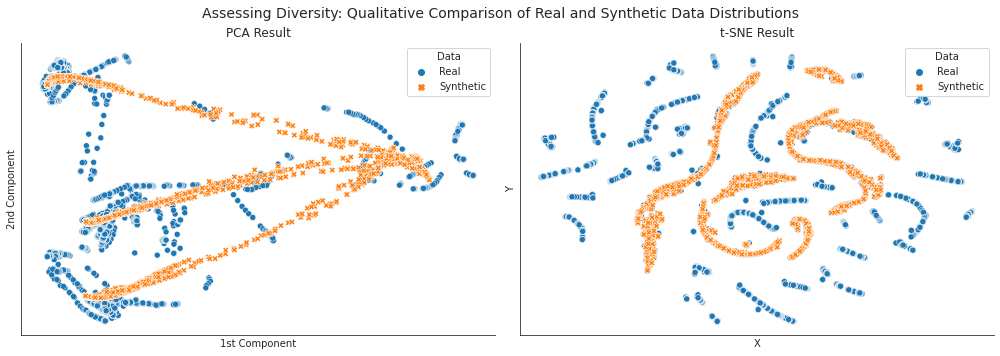

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Time Series Classification 
 
A quantitative assessment of Fidelity. We label each batch sample as either real or synthetic, then we train a classifier accordingly to see if it can distinguish between real or synthetic data. The lower the testing accuracy, the better it is.

We want to use bench-mark NLP/Time Series Architecture: GRU, LSTM, RNN, Transformers

## 1. Prepare Data

In [22]:
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(8960, 24, 18)

In [23]:
synthetic_data.shape

(8960, 24, 18)

In [24]:
n_series = real_data.shape[0]
n_series

8960

In [25]:
idx = np.arange(n_series)
idx

array([   0,    1,    2, ..., 8957, 8958, 8959])

In [26]:
n_train = int(.8*n_series) # Use 80% Training and 20% Testing
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [27]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [28]:
train_data.shape

(14336, 24, 18)

In [29]:
test_data.shape

(3584, 24, 18)

In [30]:
# Create labels: 1 is real, 0 is synthetic
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## 2. Create Classifier

Evaluate whether real and synthetic time series can be differentiated or are indistinguishable

In [31]:
ts_classifier = Sequential([GRU(18, input_shape=(24, 18), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

2022-04-29 13:23:29.704185: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [33]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 18)                2052      
                                                                 
 OUT (Dense)                 (None, 1)                 19        
                                                                 
Total params: 2,071
Trainable params: 2,071
Non-trainable params: 0
_________________________________________________________________


In [34]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [35]:
ts_classifier.evaluate(x=test_data, y=test_labels)

112/112 [==============================] - 1s 2ms/step - loss: 2.3787 - AUC: 0.7751 - accuracy: 0.7199


[2.378720998764038, 0.7751116156578064, 0.7198660969734192]

In [36]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [37]:
from matplotlib.ticker import FuncFormatter

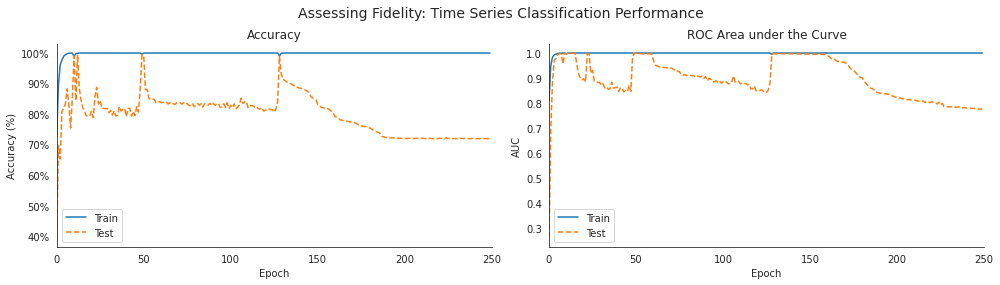

In [38]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Train on Synthetic, Test on Real (Regression Test)

- Others: 
    - Train on Real, Test on Real (check the classifier).
    - Train on Real, Test on Synthetic (check if the 2 Synthetic can fool the classifier).
    - Train on Synthetic, Test on Real (check if we can replace the Real for Synthetic in the training process).
    - Train on Synthetic, Test on Synthetic (check if we can replace the real dataset entirely)
- Take in a window and try to predict the next time step.  

In [39]:
real_data = real_data
real_data = np.array(real_data)[:len(synthetic_data)]

In [40]:
real_data.shape, synthetic_data.shape

((8960, 24, 18), (8960, 24, 18))

In [41]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [42]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((7168, 23, 18), (7168, 18), (1792, 23, 18), (1792, 18))

In [43]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [44]:
synthetic_train.shape, synthetic_label.shape

((8960, 23, 18), (8960, 18))

In [47]:
def get_model():
    model = Sequential([GRU(36, input_shape=(seq_len-1, n_seq)),
                        Dense(18)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [48]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [49]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [50]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

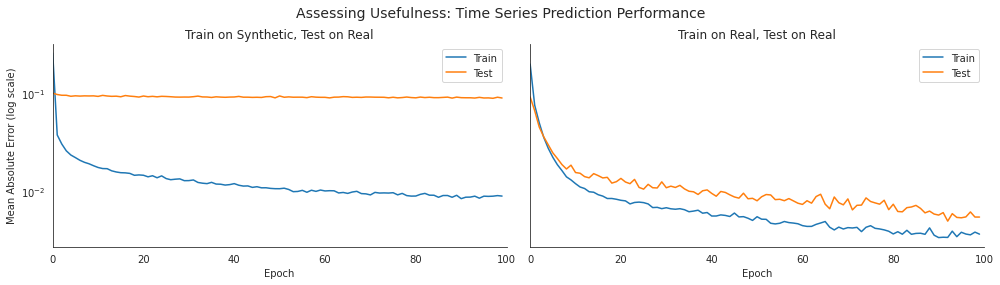

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);